In [1]:
import os

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.keras import layers, Sequential

import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


Num GPUs Available:  0


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 3

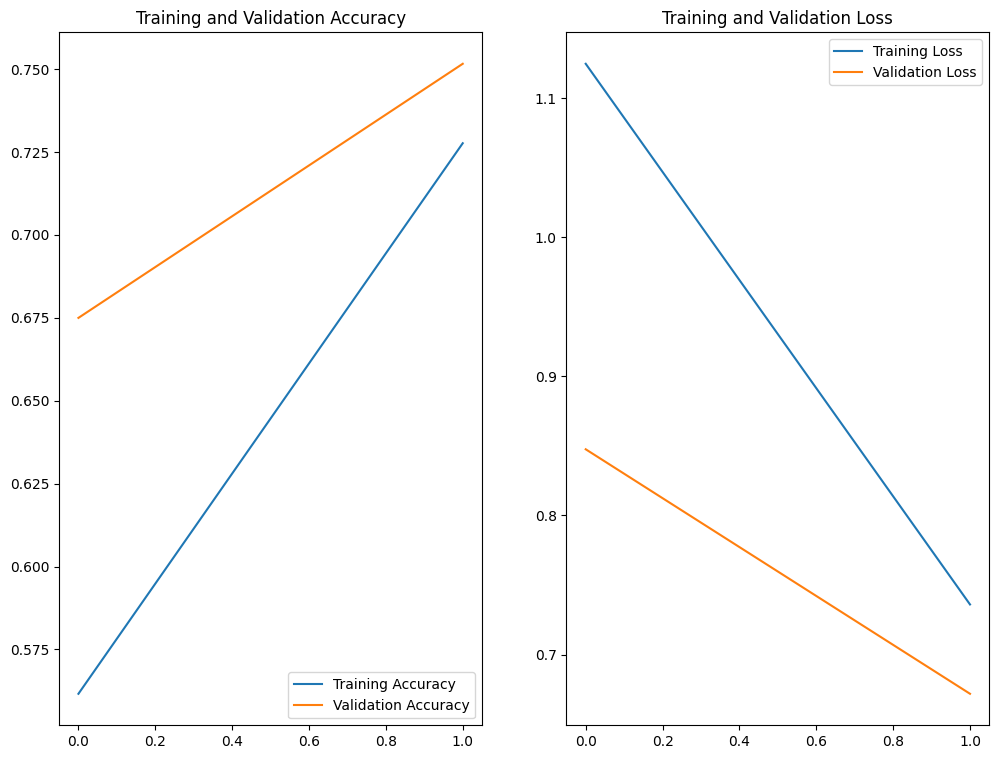

In [2]:
folderpath = r'..\database\archive'

train_filepath = os.path.join(folderpath, 'seg_train', 'seg_train')
test_filepath = os.path.join(folderpath, 'seg_test', 'seg_test')

batch_size = 64 #32
img_height = 150
img_width = 150
seed = 42

# Load dataset using keras utils from path
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_filepath,
  validation_split=0.2,
  subset="both",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_filepath,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

class_names = train_ds.class_names
print(class_names)


# cache and prefetch the data to configure dataset for performance, more info can be found at https://www.tensorflow.org/guide/data_performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## creating basic model
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)
callbacks = [
    #tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    #tf.keras.callbacks.EarlyStopping(patience=2)
]

#build model using a fast model for ouput
model = Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax', name="outputs")
])


optim = tf.keras.optimizers.Adam(learning_rate=0.0015) #default=0.001
#complie
model.compile(optimizer=optim,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#view model summary
model.summary()

#train model
epochs=2
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

#display training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



47/47 [==============================] - 8s 179ms/step


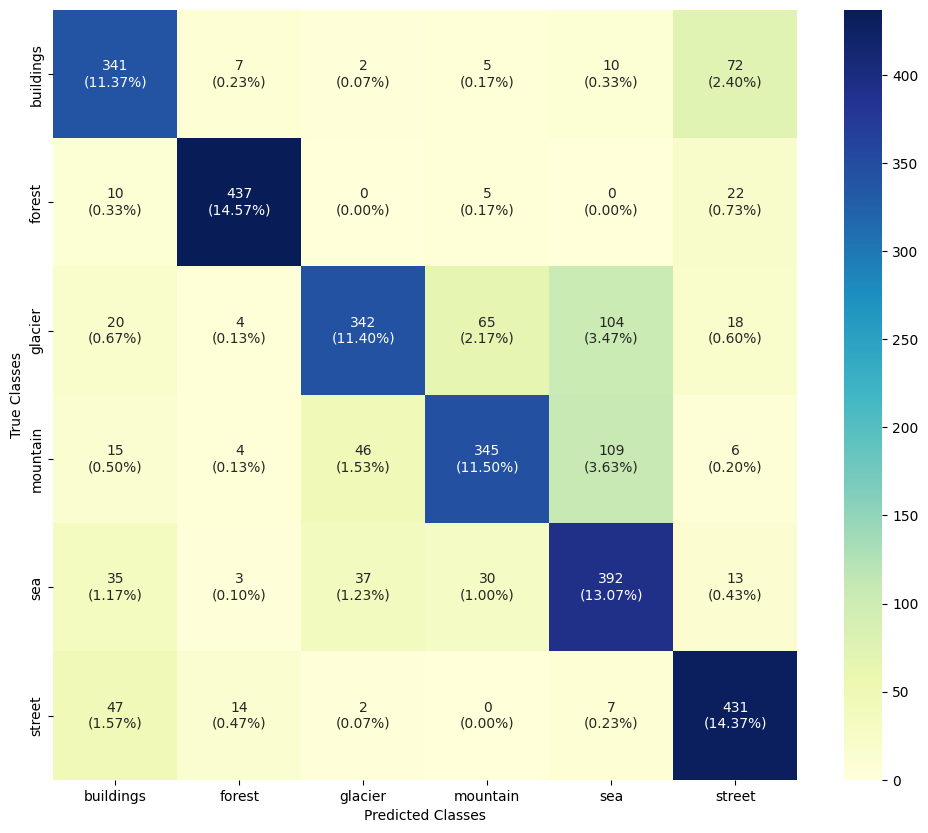

              precision    recall  f1-score   support

   buildings       0.73      0.78      0.75       437
      forest       0.93      0.92      0.93       474
     glacier       0.80      0.62      0.70       553
    mountain       0.77      0.66      0.71       525
         sea       0.63      0.77      0.69       510
      street       0.77      0.86      0.81       501

    accuracy                           0.76      3000
   macro avg       0.77      0.77      0.76      3000
weighted avg       0.77      0.76      0.76      3000



In [101]:

##############################################
#eval on test_ds
model.evaluate(test_ds)

#analyse model predictions on test dataset
predict_proba = model.predict(test_ds)
pred_labels = np.argmax(predict_proba, axis=1)

# test_labels = list(test_ds.unbatch().map(lambda x,y: y))
images, test_labels = tuple(zip(*list(test_ds.unbatch())))
cf_mtx = confusion_matrix(test_labels, pred_labels)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=class_names, yticklabels=class_names,
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

print(classification_report(test_labels, pred_labels, target_names=class_names))


##decide good number of epochs

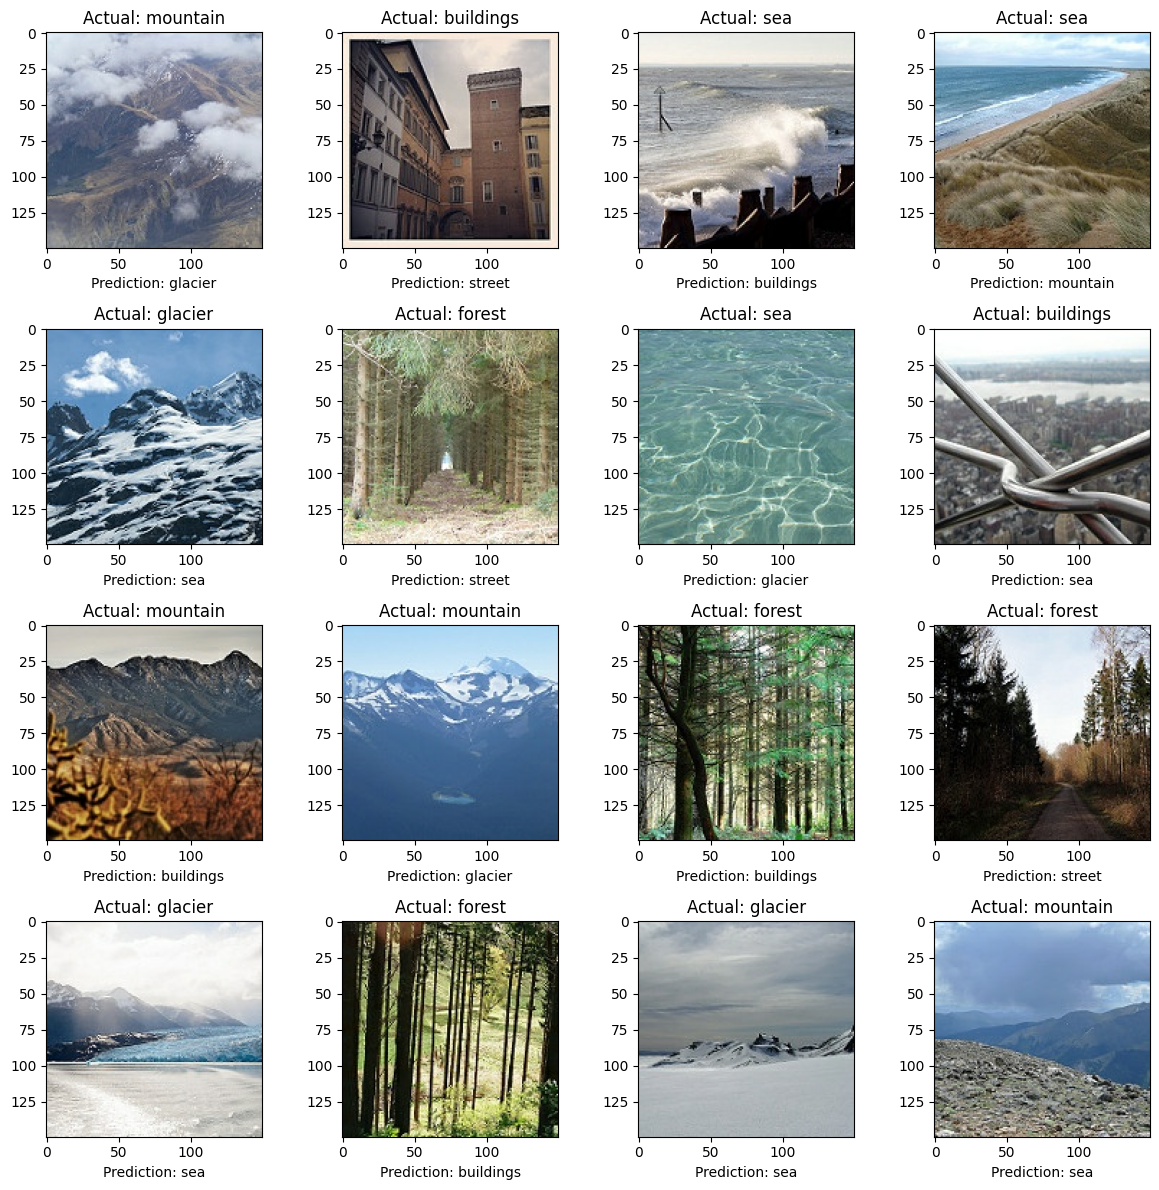

In [122]:
def display_wrongly_predicted(real_labels,pred_labels,img_ds,num_samples=16):

    arr_wrong = (test_labels != pred_labels).nonzero()
    arr_wrong = [i for x in arr_wrong for i in x]
    rs = np.random.randint(len(arr_wrong), size=num_samples)
    selected_arr_wrong = [arr_wrong[x] for x in rs]

    fig, axes = plt.subplots(nrows=(int(np.ceil(num_samples/4))),ncols=4, figsize=(12,12))

    for c, ax in enumerate(axes.flatten()):
        if num_samples == c:
            break
        i = selected_arr_wrong[c]
        actual_label,pred_label = class_names[test_labels[i]], class_names[pred_labels[i]]
        arr = img_ds
        ax.imshow(arr[i]/255)
        ax.set_title("Actual: "+ actual_label)
        ax.set_xlabel("Prediction: "+ pred_label)
    plt.tight_layout()
    plt.show()
    

display_wrongly_predicted(test_labels,pred_labels,images,num_samples=16)

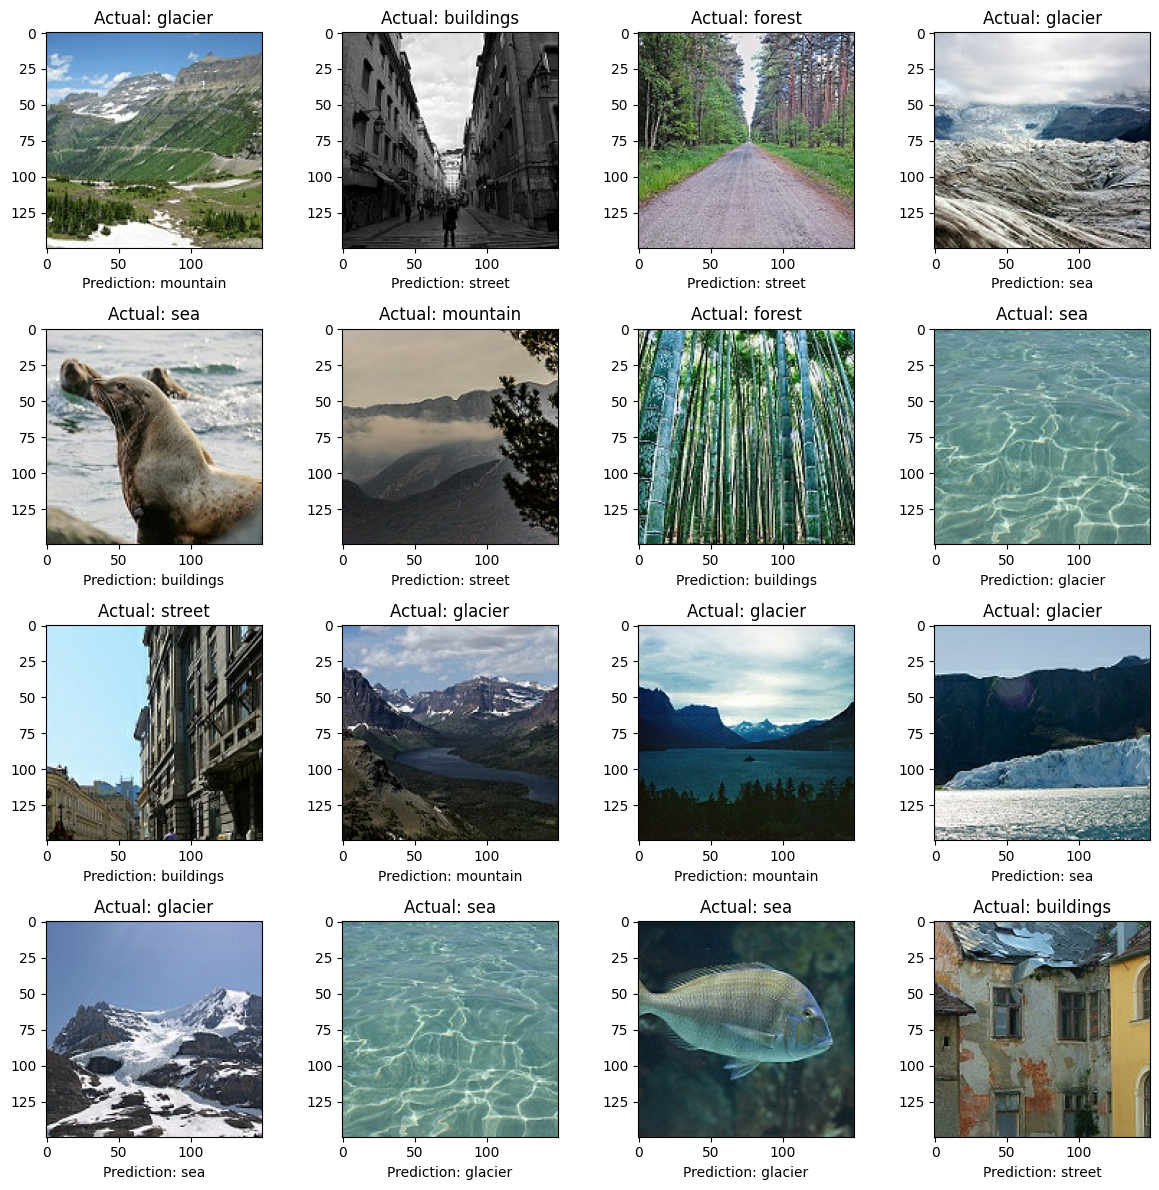

In [124]:

arr_wrong = (test_labels != pred_labels).nonzero()
arr_wrong = [i for x in arr_wrong for i in x]
rs = np.random.randint(len(arr_wrong), size=16)
selected_arr_wrong = [arr_wrong[x] for x in rs]

t_ds = list(test_ds.unbatch())

fig, axes = plt.subplots(nrows=4,ncols=4, figsize=(12,12))

for c, ax in enumerate(axes.flatten()):
    i = selected_arr_wrong[c]
    actual_label,pred_label = class_names[test_labels[i]], class_names[pred_labels[i]]
    arr = t_ds[i]
    ax.imshow(arr[0]/255)
    ax.set_title("Actual: "+ actual_label)
    ax.set_xlabel("Prediction: "+ pred_label)
plt.tight_layout()
plt.show()

# for i in selected_arr_wrong:
#     actual_label,pred_label = class_names[test_labels[i]], class_names[pred_labels[i]]
#     arr = t_ds[i]
#     plt.imshow(arr[0]/255)
#     plt.title("Actual: "+ actual_label+ "    Prediction: "+ pred_label)
#     plt.show()
